In [62]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

### Some visual insights

In [63]:
def load_osm_data(file_path):
    with open(file_path, "r") as file:
        osm_data = json.load(file)
    return osm_data
    
def osm_data_to_dataframe(osm_data):
    data_list = []
    for point in osm_data["planet_osm_point"]:
        data_list.append(point)
    return pd.DataFrame(data_list)

def plot_distribution(data, column_name, xlabel):
    plt.figure(figsize=(12, 6))
    sns.countplot(data[column_name])
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

def plot_scatter(data):
    plt.figure(figsize=(12, 6))
    data[[ 'Latitude', 'Longitude']] = data['way'].str.extract(r'POINT \(([-.\d]+) ([-.\d]+)\)').astype(float)
    sns.scatterplot(data=data, x='Longitude', y='Latitude')
    plt.show()

In [64]:
file_paths = ['planet_osm_point_202312122304.json', 'planet_osm_point_202312122304_2.json', 'planet_osm_point_202312122304_3.json']
all_dataframes = []
for file_path in file_paths:
    osm_data = load_osm_data(file_path)
    df = osm_data_to_dataframe(osm_data)
    all_dataframes.append(df)

combined_df = pd.concat(all_dataframes, ignore_index=True)


In [65]:
combined_df

,osm_id,access,addr:housename,addr:housenumber,addr:interpolation,admin_level,aerialway,aeroway,amenity,area,...,tourism,tower:type,tunnel,water,waterway,wetland,width,wood,z_order,way
0,7883440301,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (3.4608704 47.9681731)
1,7883440300,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (3.4583116 47.9678857)
2,7883440298,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (3.4534487 47.9673272)
3,814612869,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (3.455245 47.9668981)
4,7883440299,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (3.4556991 47.9675768)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103135,6481223070,None,None,12,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (2.2537205 47.8412597)
103136,6481223079,None,None,2,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (2.2527523 47.8401223)
103137,6481225705,None,None,3,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (2.2521681 47.8405172)
103138,6481223023,None,None,1,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,POINT (2.252342 47.8404217)


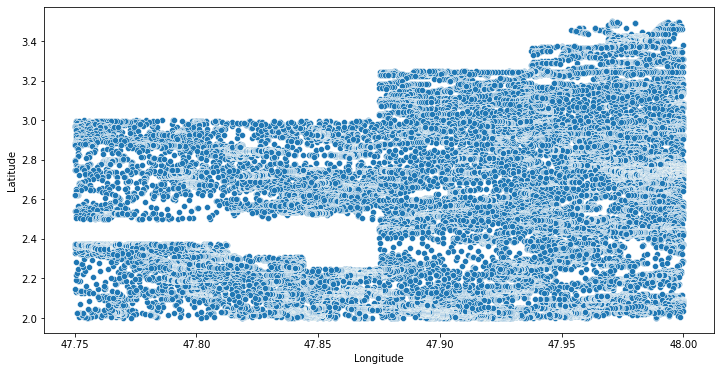

In [66]:
plot_scatter(combined_df)

In [67]:
X = combined_df['Longitude']
Y = combined_df['Latitude']

In [68]:
combined_df = combined_df.drop(columns=['way', 'osm_id'])

### Fusion of positions 

In [69]:
import numpy as np

num_cells = 100

min_longitude = np.min(X)
max_longitude = np.max(X)

min_latitude = np.min(Y)
max_latitude = np.max(Y)

delta_longitude = (max_longitude - min_longitude)/num_cells
delta_latitude =  (max_latitude - min_latitude)/num_cells

x_values = np.linspace(min_longitude, max_longitude, num_cells)
y_values = np.linspace(min_latitude, max_latitude, num_cells)

Longitude, Latitude = np.meshgrid(x_values, y_values, indexing='xy')

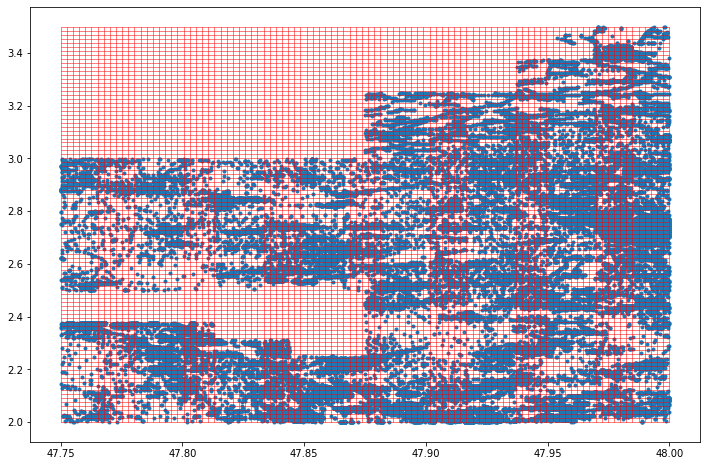

In [70]:
plt.figure(figsize=(12, 8))
plt.scatter(X, Y, marker='.')
plt.plot(Longitude.T, Latitude.T, color='red', linestyle = '-', linewidth = 0.5)
plt.plot(Longitude, Latitude, color='red', linestyle = '-', linewidth = 0.5)
plt.show()

In [71]:
regions = {}

for position in combined_df.iterrows():
    longitude_ = position[1].Longitude
    latitude_ = position[1].Latitude
    # break

    i_, j_ = int(((longitude_ - min_longitude)// delta_longitude)), int(((latitude_ - min_latitude)// delta_latitude))
    if (i_, j_) in regions:
        regions[(i_, j_)].append(position)
    else:
        regions[(i_, j_)] = [position]

In [72]:
# print(regions.keys())


In [73]:
sizes_of_regions = [len(values) for key, values in regions.items()]
print("Size of the largest area : ", np.max(sizes_of_regions))
print("Size of the smallest area : ", np.min(sizes_of_regions))
print("Mean of sizes : ", np.mean(sizes_of_regions))
print("Standard deviation of sizes : ", np.std(sizes_of_regions))

Size of the largest area :  991
Size of the smallest area :  1
Mean of sizes :  18.078878177037687
Standard deviation of sizes :  50.24042895899957


In [74]:
for key, value in regions.items():
    # print(type(value[0][1]))
    # break
    dataframes_list = [val[1].to_frame().T for val in value]
    # print(dataframes_list[0])
    # print(dataframes_list[1])
    # break
    result_df = pd.concat(dataframes_list, ignore_index=True)
    regions[key] = result_df

In [75]:
for key, val in regions.items():
    print(val)
    break

  access addr:housename addr:housenumber addr:interpolation admin_level  \
0   None           None             None               None        None   
1   None           None             None               None        None   
2   None           None             None               None        None   

  aerialway aeroway amenity  area barrier  ... tower:type tunnel water  \
0      None    None    None  None    None  ...       None   None  None   
1      None    None    None  None    None  ...       None   None  None   
2      None    None    None  None    None  ...       None   None  None   

  waterway wetland width  wood z_order  Latitude  Longitude  
0     None    None  None  None    None   3.46087  47.968173  
1     None    None  None  None    None  3.458312  47.967886  
2     None    None  None  None    None  3.455699  47.967577  

[3 rows x 69 columns]


### Creation of the Vocabulary

In [76]:
# combined_df2 = combined_df.copy()

# columns_to_drop = []

# for col in combined_df.columns: 
#     print(col, combined_df[col].isnull().sum()==len(combined_df))
#     if combined_df[col].empty: 
#         columns_to_drop.append(col)       
    

# print(columns_to_drop)
# combined_df.drop(columns=columns_to_drop, inplace=True)

In [77]:
variables = combined_df.columns.tolist()
vocabularies = []

for i in range (0, len(variables)-2):
    values = combined_df[variables[i]].unique()
    values = np.array(values)
    voc = {value: i for i, value in enumerate(values)}
    vocabularies.append(voc)

In [78]:
print(len(variables))

69


In [79]:
print(vocabularies[60]) #Variable entièrement nulle
print(variables[60])

{None: 0}
tunnel


In [80]:
barycenters = {}

for key, val in regions.items():
    longitude = np.array(val['Longitude'])
    latitude = np.array(val['Latitude'])
    
    mean_longitude = np.mean(longitude)
    mean_latitude = np.mean(latitude)

    barycenters[key] = (mean_longitude, mean_latitude)

### Vectorization

In [81]:
X = []
dim = len(variables)

for key, value in regions.items():
    x = np.zeros(dim)
    for i, variable in enumerate(variables):
        x[i] = value[variable].count()
    X.append(x)
    
X = np.array(X)

In [82]:
X = X[:, :-2]
print(X.shape)
print(X[0])

(5705, 67)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 3. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [120]:
key_ids = {key:i for i, key in enumerate(regions)}
id_to_key = {val:key for key, val in key_ids.items()} 

In [121]:
# print(key_ids)

##### PCA transformation

In [132]:
from sklearn.decomposition import PCA
 
pca = PCA(n_components=3)

X_train = pca.fit_transform(X)

vectors = {}

i = 0
for key, value in key_ids.items():
    vectors[value] = X_train[i]
    i += 1

In [133]:
df_train = pd.DataFrame(vectors).T
df_train

,0,1,2
0,-11.802973,0.029198,2.309294
1,-11.843980,0.004372,-0.499897
2,-11.469552,0.071965,-1.581996
3,-11.782469,0.041611,3.713889
4,-11.837086,-0.004060,-0.486134
...,...,...,...
5700,5.154321,-1.842816,-0.910370
5701,-11.648146,0.111729,-0.462642
5702,-11.603371,0.135101,-1.854819
5703,-8.629246,-0.203720,-0.531426


In [134]:
kmeans = KMeans(n_clusters=1000, random_state=42, n_init='auto').fit(df_train)

kmeans_labels = kmeans.labels_
cluster_data = {}
for i in range(kmeans.n_clusters):
    cluster_data[i] = [j for j, label in enumerate(kmeans_labels) if label==i]


In [135]:
for cluster, data_entries in cluster_data.items():
    print(f"Cluster {cluster} contains data entries: {data_entries}")

Cluster 0 contains data entries: [5, 28, 29, 87, 90, 114, 115, 118, 131, 137, 147, 156, 157, 172, 219, 228, 235, 310, 350, 353, 387, 388, 390, 395, 398, 413, 418, 423, 432, 456, 460, 466, 485, 493, 506, 509, 529, 530, 549, 557, 566, 570, 579, 584, 593, 602, 621, 634, 637, 638, 647, 660, 661, 1253, 1255, 1284, 1429, 1462, 1467, 1469, 1860, 2083, 2116, 2125, 2135, 2136, 2228, 2229, 2230, 2232, 2486, 2490, 2491, 2495, 2516, 2539, 2545, 2584, 2630, 2836, 2861, 3040, 3069, 3070, 3219, 3269, 3521, 3596, 3630, 3639, 4335, 4795, 5003, 5163, 5175, 5233, 5460, 5524, 5567]
Cluster 1 contains data entries: [4582]
Cluster 2 contains data entries: [2164, 3293, 3295]
Cluster 3 contains data entries: [3328]
Cluster 4 contains data entries: [5105]
Cluster 5 contains data entries: [3605]
Cluster 6 contains data entries: [1343, 4403, 4485, 4725]
Cluster 7 contains data entries: [854]
Cluster 8 contains data entries: [62]
Cluster 9 contains data entries: [1388, 3762, 4186, 4306, 4762, 4904]
Cluster 10 con

In [136]:
print(vocabularies[1])
print(variables[1])

{None: 0, '3 Domaine des Grands Marais': 1}
addr:housename


In [155]:
sample = combined_df.iloc[0]
sample_x = []
for variable in variables[:-2]:
    sample_x.append(sample[variable])
sample_x = ( np.array(sample_x) != None) * 1

In [156]:
print(sample_x.reshape(1, -1))


[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [157]:
X_test = pca.transform(sample_x.reshape(1, -1))

In [158]:
y_pred = kmeans.predict(X_test)

In [159]:
print(y_pred)

[586]


In [161]:
cluster_data[586]

[1,
 4,
 12,
 19,
 91,
 103,
 104,
 134,
 210,
 217,
 218,
 221,
 226,
 244,
 281,
 361,
 368,
 399,
 415,
 433,
 445,
 459,
 467,
 478,
 498,
 510,
 556,
 569,
 592,
 635,
 640,
 653,
 658,
 918,
 1007,
 1008,
 1228,
 1256,
 1340,
 1391,
 1404,
 1924,
 2006,
 2009,
 2069,
 2078,
 2081,
 2093,
 2224,
 2225,
 2280,
 2401,
 2447,
 2498,
 2508,
 2511,
 2513,
 2517,
 2529,
 2530,
 2535,
 2543,
 2544,
 2548,
 2553,
 2572,
 2579,
 2621,
 2633,
 2684,
 2819,
 2838,
 3041,
 3054,
 3056,
 3059,
 3062,
 3151,
 3152,
 3153,
 3155,
 3169,
 3170,
 3171,
 3172,
 3173,
 3175,
 3183,
 3218,
 3250,
 3251,
 3361,
 3362,
 3365,
 3640,
 3641,
 3666,
 3678,
 3679,
 3692,
 3693,
 3696,
 3768,
 3853,
 3854,
 3856,
 3860,
 3863,
 3894,
 3955,
 4325,
 4361,
 4375,
 4599,
 4677,
 4686,
 4694,
 4700,
 4718,
 4743,
 4752,
 4774,
 4786,
 4793,
 4801,
 4945,
 4964,
 5008,
 5009,
 5019,
 5069,
 5085,
 5118,
 5145,
 5160,
 5169,
 5196,
 5230,
 5251,
 5252,
 5260,
 5263,
 5265,
 5275,
 5288,
 5301,
 5305,
 5320,
 5327

In [164]:
id_to_key[4]

(82, 97)

In [165]:
regions[(82, 97)]

,access,addr:housename,addr:housenumber,addr:interpolation,admin_level,aerialway,aeroway,amenity,area,barrier,...,tower:type,tunnel,water,waterway,wetland,width,wood,z_order,Latitude,Longitude
0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,3.465162,47.957058
1,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,3.465166,47.957014
2,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,3.465156,47.957092
3,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,3.468313,47.957095
4,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,3.465174,47.956981


In [154]:
import sys
np.set_printoptions(threshold=sys.maxsize)
print(np.array(combined_df.iloc[34382]))

[None None '22' None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None None None None
 None None None None None None None None None None None 2.5328424
 47.849242]


In [174]:
import folium

center = barycenters[(82, 97)]

m = folium.Map([center[0], center[1]], zoom_start=12)

for i, position in regions[(82, 97)].iterrows():
    # print(position)
    folium.Marker(
        location=[position['Longitude'], position['Latitude']],
        tooltip="Click me!",
        popup="Position " + str(i),
        icon=folium.Icon(icon="green"),
    ).add_to(m)

folium.Marker(
    location=[47.9681731, 3.4608704],
    tooltip="Click me!",
    popup="Timberline Lodge",
    icon=folium.Icon(color="red"),
).add_to(m)

In [175]:
m